In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sn
x=tf.placeholder(dtype=tf.int32,shape=(3,2))
y=tf.Variable(5)
fn=x**y+x*y
g=x*fn
init=tf.global_variables_initializer()
#operations
with tf.Session() as sess:
    init.run()
    print(sess.run([fn,g],feed_dict={x:[[2,3],[5,6],[7,6]]}))

[array([[   42,   258],
       [ 3150,  7806],
       [16842,  7806]], dtype=int32), array([[    84,    774],
       [ 15750,  46836],
       [117894,  46836]], dtype=int32)]


In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_9aba6a7ecc964132bfe0a92c918ab71c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='zBETh6ci2J7NuQhMlsRcyLipsMjs90q4dPEopR0UMxL6',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_9aba6a7ecc964132bfe0a92c918ab71c.get_object(Bucket='deepl-donotdelete-pr-kzixip7pm5xm7i',Key='TOPO_DATA.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

TOPO_DATA = pd.read_csv(body,index_col='S/N')
TOPO_DATA.columns=['Easting','Northing','Spot_Height']
TOPO_DATA.head()




,Easting,Northing,Spot_Height
S/N,,,
1,544079.776,720172.309,1.012
2,543279.402,720468.302,1.021
3,543279.472,720468.390,1.025
4,542778.571,720464.031,1.032
5,544080.839,720170.246,1.046


In [3]:
#Check Nunmber of instances
print('Number of instances, No of features')
TOPO_DATA.shape[0],TOPO_DATA.shape[1]

Number of instances, No of features


(9373, 3)

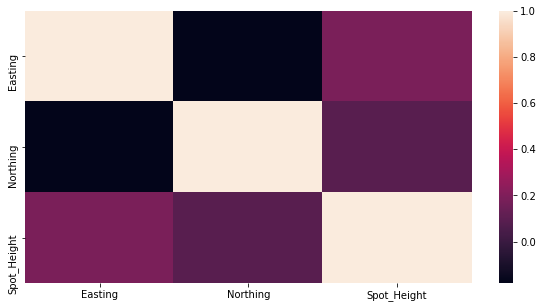

In [4]:
#Explore the data through visualization
pl.figure(figsize=(10,5))
sn.heatmap(TOPO_DATA.corr(),cbar=True)
pl.show()


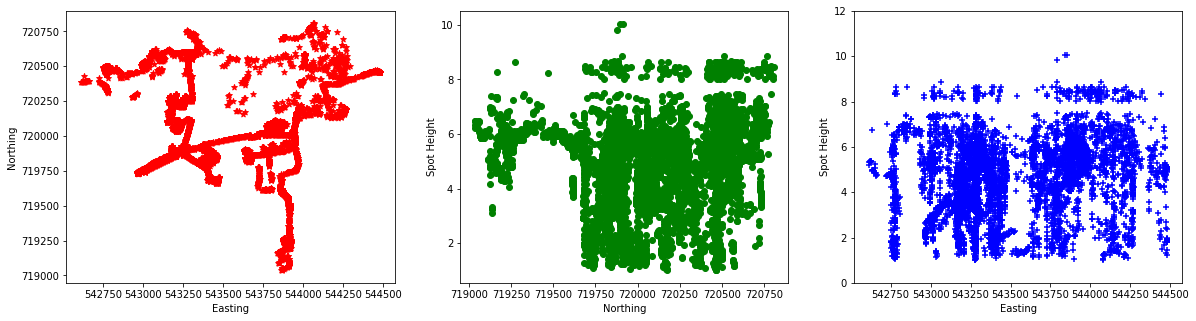

In [5]:
#Plots to explore the relationships among variables
pl.figure(figsize=(20,5))
pl.subplot(1,3,3)
pl.ylabel("Spot Height")
pl.xlabel('Easting')
pl.scatter(list(TOPO_DATA['Easting'].values),list(TOPO_DATA['Spot_Height'].values), c="blue", marker='+')
pl.ylim(0,12)
pl.subplot(132)
pl.ylabel("Spot Height")
pl.xlabel('Northing')
pl.scatter(list(TOPO_DATA['Northing'].values),list(TOPO_DATA['Spot_Height'].values), c="green", marker='o')
pl.subplot(131)
pl.ylabel("Northing")
pl.xlabel('Easting')
pl.scatter(list(TOPO_DATA['Easting'].values),list(TOPO_DATA['Northing'].values), c="red", marker='*')
pl.show()


In [6]:
#Create data split function
def data_split(data):
    random_state=1
    Split_idx=np.random.permutation(len(data))
    n_ins=int(0.20*len(data))#no of instances
    Test_idx=Split_idx[:n_ins]
    Train_idx=Split_idx[n_ins:]
    return data.iloc[Train_idx],data.iloc[Test_idx]

#split data into train, validate, test datasets
Train_data,Test_Data=data_split(TOPO_DATA)
#shapes of various datasets
Test_Data.shape,Train_data.shape,TOPO_DATA.shape

((1874, 3), (7499, 3), (9373, 3))

In [7]:
#Create validation data from Train_data
Remain_Train_data,Val_data=data_split(Train_data)
#Val_data.shape,Remain_Train_data.shape

#split datasets into feature dataset and target dataset
Train_target=Remain_Train_data["Spot_Height"]
cols=["Easting","Northing"]
Train_features=Remain_Train_data[cols].values

#validation data 
Val_target=Val_data["Spot_Height"].values
Val_features=Val_data[cols].values
#shapes of target datasets
Val_target.shape,Train_target.shape

((1499,), (6000,))

In [8]:
#Normalizing the datasets for easy model training and effective model performance
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler_fit=scaler.fit(Train_features)
Normalized_Train=scaler_fit.transform(Train_features)
Normalized_val=scaler_fit.transform(Val_features)
N_Test=scaler_fit.transform(Test_Data[cols])
Test_target=Test_Data["Spot_Height"].values

In [9]:
# Append the feature for the bias term.
#------------------------------------------------
def append_bias(features,target):
    n_samples = features.shape[0]
    n_features = features.shape[1]
    intercept_feature = np.zeros((n_samples,1))
    X = np.concatenate((features,intercept_feature),axis=1)
    X = np.reshape(X,[n_samples,n_features +1])
    Y = np.reshape(target,[n_samples,1])
    return X,Y

In [10]:
X_input,Y_input = append_bias(Normalized_Train,Train_target)
num_features = X_input.shape[1]

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [11]:
#Create TensorFlow ops for placeholders, weights, and weight initialization
#-------------------------------------------------------------------------
X = tf.placeholder(tf.float32,[None,num_features])
Y = tf.placeholder(tf.float32,[None,1])
w = tf.Variable(tf.random_normal((num_features,1)),name='weights')
init = tf.global_variables_initializer()

In [12]:
# Define the different TensorFlow ops and input parameters for Cost and Optimization.
#-------------------------------------------------------------------------------------
learning_rate = 0.01
num_epochs = 500
cost_list = []
pred = tf.matmul(X,w)
error = pred - Y
cost = tf.reduce_mean(tf.square(error))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [13]:
# Execute the gradient-descent learning
#--------------------------------------
with tf.Session() as sess:
    sess.run(init)
    for i in np.arange(num_epochs):
        cost_list.append(sess.run(cost,feed_dict={X:X_input,Y:Y_input}))
        sess.run(train_op,feed_dict={X:X_input,Y:Y_input})
        error_ = sess.run(error,{X:X_input,Y:Y_input})
        pred_ = sess.run(pred,{X:X_input})
        #print('MSE in training:',cost_list)

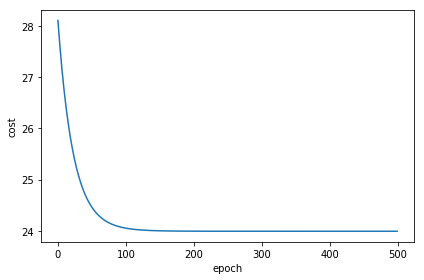

In [14]:
# Plot the reduction in cost over iterations or epochs
#-----------------------------------------------------
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cost_list)
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()
plt.tight_layout()
plt.show()

Text(0,0.5,'Predicted Spot_Height')

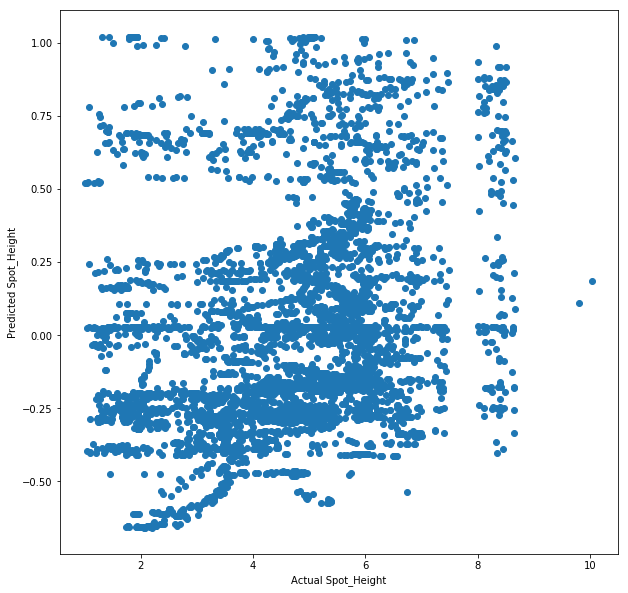

In [15]:
#Plot the Predicted Spot_Height vs the Actual 
#---------------------------------------------
#plt.figure(figsize=(20,5))
fig,ax = plt.subplots(figsize=(10,10))
plt.scatter(Train_target,pred_)
ax.set_xlabel('Actual Spot_Height')
ax.set_ylabel('Predicted Spot_Height')

The regression analysis using Tensorflow failed woefully as observed with SGDRegressor in previous Note. Now let make up for a trial with deep learning 

In [79]:
import keras
from keras import models
from keras import layers


def build_model():
    model = models.Sequential()
    model.add(layers.Dense(1024, activation='relu',input_shape=(Normalized_Train.shape[1],)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1))
    
    #compile model
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae','mse'])
    return model
#create an instance of the class
model=build_model()
model.summary

<bound method Container.summary of <keras.models.Sequential object at 0x7f3f6ee86048>>

In [ ]:
#model=build_model()
num_epochs=500
class PrintDot(keras.callbacks.Callback):
    def epoch_end(self,epoch,logs):
        if epoch % 100==0: print('')
        print('.',end='')
        
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history=model.fit(Normalized_Train,Train_target,validation_data=(Normalized_val,Val_target),epochs=num_epochs,batch_size=100,verbose=0,callbacks=[early_stop,PrintDot()])
hist_Dataframe=pd.DataFrame(history.history)
hist_Dataframe['Epoch']=history.epoch
#Display history details
hist_Dataframe.tail(5)

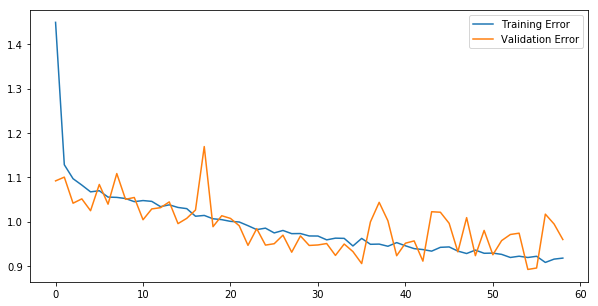

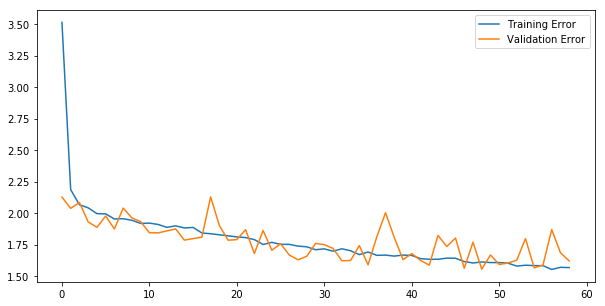

In [78]:
def plot_hostory(history):
    hist_Dataframe=pd.DataFrame(history.history)
    hist_Dataframe['Epoch']=history.epoch
    #plot
    fig,ax = plt.subplots(figsize=(10,5))
    #plt.figure()
    plt.plot(hist_Dataframe['Epoch'],hist_Dataframe['mean_absolute_error'],label='Training Error')
    plt.plot(hist_Dataframe['Epoch'],hist_Dataframe['val_mean_absolute_error'],label='Validation Error')
    plt.legend()
    plt.xlabel=('Epoch')
    plt.ylabel=('Mean Asolute Error[Spot Height]')
    
    fig,ax = plt.subplots(figsize=(10,5))
    plt.plot(hist_Dataframe['Epoch'],hist_Dataframe['mean_squared_error'],label='Training Error')
    plt.plot(hist_Dataframe['Epoch'],hist_Dataframe['val_mean_squared_error'],label='Validation Error')
    plt.legend()
    plt.xlabel=('Epoch')
    plt.ylabel=('Mean Squared Error[Spot Height]')
    plt.show()
plot_hostory(history)   

In [44]:
prd_=model.predict(N_Test)

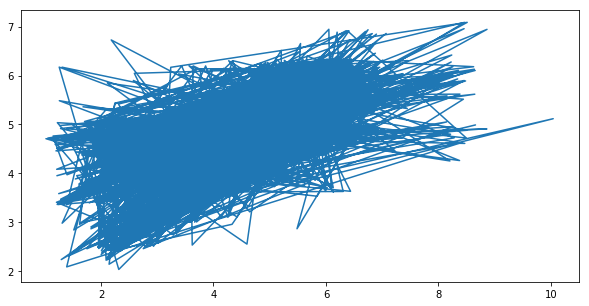

In [45]:
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(Test_target,prd_)
plt.show()

In [67]:
Test_target[:5],prd_[:5]


(array([ 5.275,  2.203,  1.979,  3.704,  2.765]), array([[ 5.31540346],
        [ 3.49305224],
        [ 5.11255121],
        [ 6.13958502],
        [ 4.6687417 ]], dtype=float32))